# Prompt Chaining
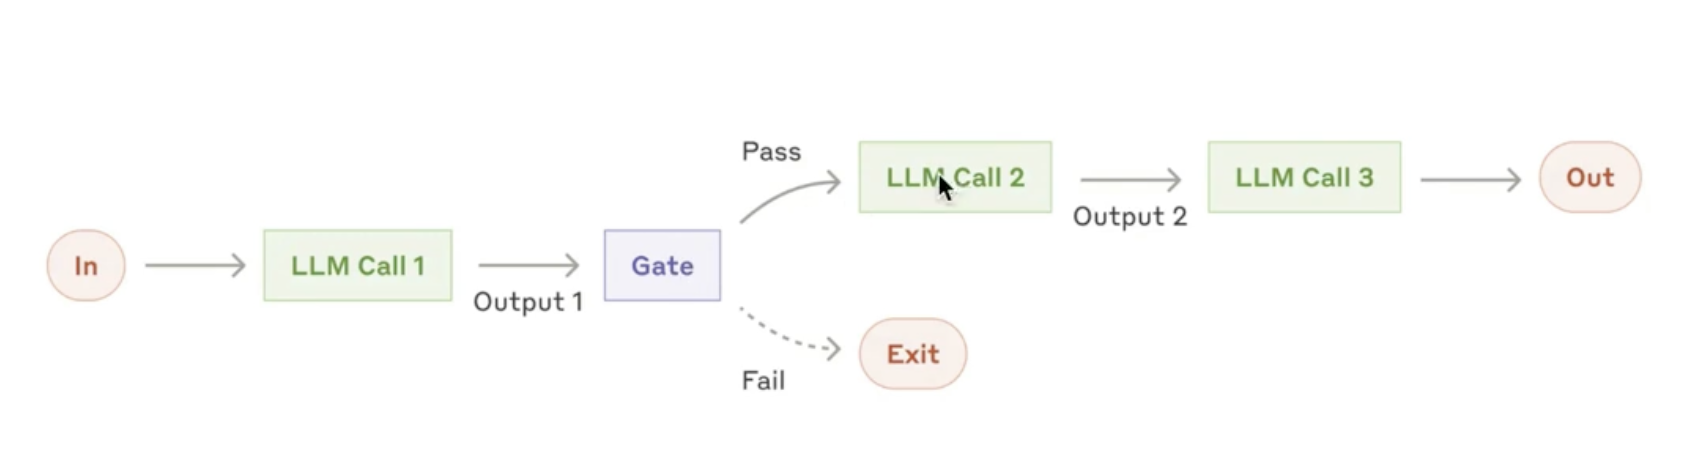

- 작업들을 단계들의 순서로 쪼개서 각 LLM 호출이 이전 단계의 호출을 받음.
- 고정된 하위 작업으로 깔끔하게 분해할 수 있을 때 사용
- 주요 목표는 더 높은 정확도를 얻는 것. -> 속도는 조금 더 느림
- example: 홍보 문안, 번역, 문서 개요
- Gate : 프로세스가 잘 진행되고 있는지 확인하는 검증 단계

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str

class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str

class IngredientsOutput(BaseModel):
    ingredients: list[Ingredient]

In [18]:
# nodes coming soon
def list_ingredients(state: State):
    structured_llm = llm.with_structured_output(IngredientsOutput)
    response = structured_llm.invoke(f"List 5-8 ingredients needed to make {state['dish']}")

    return {"ingredients": response.ingredients}

def create_recipe(state: State):
    response = llm.invoke(f"Write a step by step cooking instruction for {state['dish']} using these ingredients {state['ingredients']}")

    return {"recipe_steps": response.content}
    
def describe_plating(state: State):
    response = llm.invoke(f"Describe how to beautifully plate this dish {state['dish']} based on this recipe {state['recipe_steps']}")

    return {"plate_description": response.content}

def gate(state: State):
    ingredients = state["ingredients"]

    if len(ingredients) > 8 or len(ingredients) < 3:
        return False
    
    return True

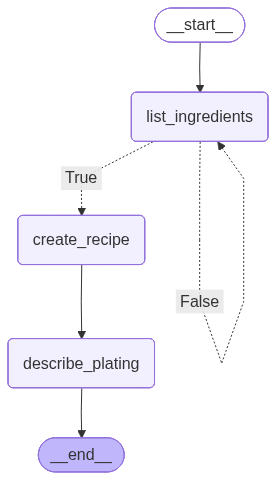

In [20]:
graph_builder = StateGraph(State)
graph_builder.add_node(list_ingredients.__name__, list_ingredients)
graph_builder.add_node(create_recipe.__name__, create_recipe)
graph_builder.add_node(describe_plating.__name__, describe_plating)

graph_builder.add_edge(START, list_ingredients.__name__)
graph_builder.add_conditional_edges(list_ingredients.__name__, gate, {True: create_recipe.__name__, False: list_ingredients.__name__})
graph_builder.add_edge(create_recipe.__name__, describe_plating.__name__)
graph_builder.add_edge(describe_plating.__name__, END)

graph = graph_builder.compile()
graph

In [17]:
graph.invoke({"dish": "hummus"})

{'dish': 'hummus',
 'ingredients': [Ingredient(name='Chickpeas', quantity='1', unit='can (15 oz)'),
  Ingredient(name='Tahini', quantity='1/4', unit='cup'),
  Ingredient(name='Olive oil', quantity='2', unit='tablespoons'),
  Ingredient(name='Garlic', quantity='2', unit='cloves'),
  Ingredient(name='Lemon juice', quantity='2', unit='tablespoons'),
  Ingredient(name='Ground cumin', quantity='1', unit='teaspoon'),
  Ingredient(name='Salt', quantity='1/2', unit='teaspoon'),
  Ingredient(name='Water', quantity='2-4', unit='tablespoons')],
 'recipe_steps': 'Here’s a step-by-step guide to making delicious hummus using your specified ingredients:\n\n### Ingredients:\n- 1 can (15 oz) Chickpeas\n- 1/4 cup Tahini\n- 2 tablespoons Olive oil\n- 2 cloves Garlic\n- 2 tablespoons Lemon juice\n- 1 teaspoon Ground cumin\n- 1/2 teaspoon Salt\n- 2-4 tablespoons Water\n\n### Instructions:\n\n1. **Prepare the Chickpeas**:\n   - Open the can of chickpeas and drain the liquid. Rinse the chickpeas under cold w